In [3]:
#Install
!pip install requests pandas numpy tqdm scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [13]:
#Import
import requests
import pandas as pd
import numpy as np
import http.client, json
from urllib.parse import urlparse
import json
from tqdm import tqdm

## Premières requêtes

In [14]:
def get_data(url):
    parsed_url = urlparse(url)
    conn = http.client.HTTPConnection(parsed_url.netloc)
    conn.request("GET", parsed_url.path)
    res = conn.getresponse()
    data = res.read()
    jsondata = json.loads(data.decode("utf-8"))
    return jsondata

In [15]:
def get_match_data(match_data):
    d ={}

    d['homeTeam_name'] = match_data['event']['homeTeam']['name']
    d['homeTeam_id'] = match_data['event']['homeTeam']['id']
    d['homeTeam_score'] = match_data['event']['homeScore']['normaltime']

    d['awayTeam_name'] = match_data['event']['awayTeam']['name']
    d['awayTeam_id'] = match_data['event']['awayTeam']['id']
    d['awayTeam_score'] = match_data['event']['awayScore']['normaltime']
    d['date'] = match_data['event']['startTimestamp']

    return d

idée maintenant : créer un dictionnaire : 
- key=joueur(id), 
- value = dict= (key=matchs joués par le joueur, value=statistics)

https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/events/last/0
-> donne les id des matchs du championnat 17 sur la saisons 52186

https://www.sofascore.com/api/v1/event/12436466/lineups
-> donne les stats par joueur du match avec l'id 12436466

## Exemple sur la saison 23-24
1) On recupère la liste des id des matchs de la saison
2) on boucle sur les matchs
    -> sur chaque match, on ajoute a notre dictionnaire : 
        -> joueur : stat du match

In [16]:
players_data = {}
matches_id = []d

In [17]:
ata

In [16]:
len(matches_id)

380

Il y a 38 journées de championnat et 10 match par journée donc 380 est le bon résultat

In [ ]:
example_id = matches_id[0]
example_id

11352485

In [20]:
match_data = get_data('https://www.sofascore.com/api/v1/event/11352485')

In [19]:
for k,v in match_data['event'].items():
    print(k)
    print(v)
    print('\n')

tournament
{'name': 'Premier League', 'slug': 'premier-league', 'category': {'name': 'England', 'slug': 'england', 'sport': {'name': 'Football', 'slug': 'football', 'id': 1}, 'id': 1, 'country': {'alpha2': 'EN', 'alpha3': 'ENG', 'name': 'England', 'slug': 'england'}, 'flag': 'england', 'alpha2': 'EN'}, 'uniqueTournament': {'name': 'Premier League', 'slug': 'premier-league', 'primaryColorHex': '#3c1c5a', 'secondaryColorHex': '#f80158', 'category': {'name': 'England', 'slug': 'england', 'sport': {'name': 'Football', 'slug': 'football', 'id': 1}, 'id': 1, 'country': {'alpha2': 'EN', 'alpha3': 'ENG', 'name': 'England', 'slug': 'england'}, 'flag': 'england', 'alpha2': 'EN'}, 'userCount': 1375866, 'id': 17, 'country': {}, 'hasPerformanceGraphFeature': True, 'hasEventPlayerStatistics': True, 'displayInverseHomeAwayTeams': False, 'fieldTranslations': {'nameTranslation': {'ar': 'الدوري الإنجليزي الممتاز', 'hi': 'प्रिमियर लीग'}, 'shortNameTranslation': {}}}, 'priority': 617, 'isGroup': False, 'c

In [21]:
# Initialisation d'un dictionnaire vide pour stocker les données
dataset_dict = {}

# Parcours des IDs des matchs
for id in tqdm(matches_id): 
    match_id = str(id) 
    try:

        # Récupération des données de l'alignement (lineups) des équipes pour ce match
        data = get_data(f'https://www.sofascore.com/api/v1/event/{id}/lineups')

        # Récupération des données générales du match
        match_json = get_data(f"https://www.sofascore.com/api/v1/event/{match_id}")

        # Extraction des données pertinentes du match (traitement personnalisé via get_match_data)
        event_data = get_match_data(match_json)


        if data['confirmed']:
            for team in ["home","away"]:

                # Parcours des joueurs de l'équipe actuelle
                for player in data[team]['players']:

                     # Récupération de l'ID du joueur en tant que chaîne de caractères
                    player_id = str(player['player']['id'])

                    if player_id not in dataset_dict: #si Joueur n'est pas dans le dataset

                        player_info = { 
                            'name': player['player']['name'], 
                            'position': player['player']['position'], 
                            'id': player['player']['id']}

                        dataset_dict[player_id] = {
                            'player_info': player_info, 
                            'matches': {}}  # on lui crée un dictionnaire
                        
                    if match_id not in dataset_dict[player_id]['matches']:
                        dataset_dict[player_id]['matches'][match_id] = {}

                    dataset_dict[player_id]['matches'][match_id]['player_statistics'] = player['statistics']
                    dataset_dict[player_id]['matches'][match_id]['match_info'] = match_data
                    

    except Exception as e:
        print(f"Erreur lors du traitement du match {match_id}: {e}")

        continue

100%|██████████| 380/380 [00:17<00:00, 21.91it/s]


In [98]:
# Chemin et nom du fichier
file_path = "dataset.json"

# Sauvegarder le dictionnaire dans un fichier JSON
with open(file_path, 'w') as json_file:
    json.dump(dataset_dict, json_file, indent=4)  # indent=4 pour une meilleure lisibilité
print(f"Le fichier JSON a été enregistré sous le nom {file_path}.")


Le fichier JSON a été enregistré sous le nom dataset.json.


{
    "player_id": {
        "info": {
            ...  // Informations générales du joueur
        },
        "matches": {
            "match_id": {
                "statistics": {
                    ...  // Statistiques du joueur pour ce match
                },
                "info": {
                    ...  // Informations générales du match
                }
            }
        }
    }
}

## Modélisation

name
position
id

premier essaie sur données de match

In [22]:
data_F = {k:v for k,v in dataset_dict.items() if v['player_info']['position'] == 'F'}

In [23]:
data_F['927083']['matches']['11352485']['player_statistics']

{'totalPass': 42,
 'accuratePass': 26,
 'totalLongBalls': 2,
 'totalCross': 2,
 'aerialLost': 1,
 'aerialWon': 1,
 'duelLost': 7,
 'duelWon': 6,
 'dispossessed': 5,
 'totalContest': 6,
 'wonContest': 5,
 'blockedScoringAttempt': 1,
 'hitWoodwork': 1,
 'totalOffside': 1,
 'minutesPlayed': 90,
 'touches': 68,
 'rating': 6.9,
 'possessionLostCtrl': 29,
 'expectedGoals': 0.079,
 'ratingVersions': {'original': 6.9, 'alternative': 6.8},
 'expectedAssists': 0.0226552}

del data_F['927083']['matches']['11352485']['player_statistics']['ratingVersions']

In [23]:
data_F['927083']['matches']['11352485']['match_info']

{'event': {'tournament': {'name': 'Premier League',
   'slug': 'premier-league',
   'category': {'name': 'England',
    'slug': 'england',
    'sport': {'name': 'Football', 'slug': 'football', 'id': 1},
    'id': 1,
    'country': {'alpha2': 'EN',
     'alpha3': 'ENG',
     'name': 'England',
     'slug': 'england'},
    'flag': 'england',
    'alpha2': 'EN'},
   'uniqueTournament': {'name': 'Premier League',
    'slug': 'premier-league',
    'primaryColorHex': '#3c1c5a',
    'secondaryColorHex': '#f80158',
    'category': {'name': 'England',
     'slug': 'england',
     'sport': {'name': 'Football', 'slug': 'football', 'id': 1},
     'id': 1,
     'country': {'alpha2': 'EN',
      'alpha3': 'ENG',
      'name': 'England',
      'slug': 'england'},
     'flag': 'england',
     'alpha2': 'EN'},
    'userCount': 1375866,
    'id': 17,
    'country': {},
    'hasPerformanceGraphFeature': True,
    'hasEventPlayerStatistics': True,
    'displayInverseHomeAwayTeams': False,
    'fieldTransl

In [24]:
data_F['927083']['matches']['11352485']['match_info']['event']['startTimestamp']

1714831200

In [24]:
for player_id in data_F.keys():

    for match_id in data_F[player_id]['matches'].keys():
        match = data_F[player_id]['matches'][match_id]
        match['player_statistics']['startTimestamp'] = match['match_info']['event']['startTimestamp']
        # Supprimer les clés inutiles
        match['player_statistics'].pop('ratingVersions', None)
        match.pop('match_info', None)

In [26]:
data_F['927083']["matches"].keys()

dict_keys(['11352485', '11352519', '11352549', '11352434', '11352457', '11352614', '11352325', '11352355', '11352394', '11352599', '11352421', '11352339', '11352356', '11352393', '11352660', '11352672', '11352304', '11352628', '11352643', '11352654', '11352456', '11352543', '11352615', '11352309', '11352358'])

In [27]:
data_F['927083']["matches"]['11352485']

{'player_statistics': {'totalPass': 42,
  'accuratePass': 26,
  'totalLongBalls': 2,
  'totalCross': 2,
  'aerialLost': 1,
  'aerialWon': 1,
  'duelLost': 7,
  'duelWon': 6,
  'dispossessed': 5,
  'totalContest': 6,
  'wonContest': 5,
  'blockedScoringAttempt': 1,
  'hitWoodwork': 1,
  'totalOffside': 1,
  'minutesPlayed': 90,
  'touches': 68,
  'rating': 6.9,
  'possessionLostCtrl': 29,
  'expectedGoals': 0.079,
  'expectedAssists': 0.0226552,
  'startTimestamp': 1714831200}}

In [25]:
for player_id in data_F.keys():
    for match_id in data_F[player_id]['matches'].keys():
        data_F[player_id]['matches'][match_id] = data_F[player_id]['matches'][match_id]['player_statistics']

In [26]:
data_F['927083']["matches"]['11352485']

{'totalPass': 42,
 'accuratePass': 26,
 'totalLongBalls': 2,
 'totalCross': 2,
 'aerialLost': 1,
 'aerialWon': 1,
 'duelLost': 7,
 'duelWon': 6,
 'dispossessed': 5,
 'totalContest': 6,
 'wonContest': 5,
 'blockedScoringAttempt': 1,
 'hitWoodwork': 1,
 'totalOffside': 1,
 'minutesPlayed': 90,
 'touches': 68,
 'rating': 6.9,
 'possessionLostCtrl': 29,
 'expectedGoals': 0.079,
 'expectedAssists': 0.0226552,
 'startTimestamp': 1714831200}

In [30]:
data_F['927083']["matches"]

{'11352485': {'totalPass': 42,
  'accuratePass': 26,
  'totalLongBalls': 2,
  'totalCross': 2,
  'aerialLost': 1,
  'aerialWon': 1,
  'duelLost': 7,
  'duelWon': 6,
  'dispossessed': 5,
  'totalContest': 6,
  'wonContest': 5,
  'blockedScoringAttempt': 1,
  'hitWoodwork': 1,
  'totalOffside': 1,
  'minutesPlayed': 90,
  'touches': 68,
  'rating': 6.9,
  'possessionLostCtrl': 29,
  'expectedGoals': 0.079,
  'expectedAssists': 0.0226552,
  'startTimestamp': 1714831200},
 '11352519': {'totalPass': 31,
  'accuratePass': 18,
  'totalLongBalls': 3,
  'accurateLongBalls': 2,
  'goalAssist': 1,
  'totalCross': 1,
  'aerialWon': 1,
  'duelLost': 4,
  'duelWon': 4,
  'challengeLost': 1,
  'dispossessed': 2,
  'totalContest': 2,
  'wonContest': 1,
  'bigChanceCreated': 1,
  'bigChanceMissed': 1,
  'shotOffTarget': 1,
  'onTargetScoringAttempt': 1,
  'blockedScoringAttempt': 1,
  'goals': 1,
  'interceptionWon': 1,
  'wasFouled': 2,
  'minutesPlayed': 90,
  'touches': 52,
  'rating': 8.2,
  'posse

In [27]:
# Identifier toutes les features possibles
all_keys = set()
for match_id, stats in data_F['927083']["matches"].items():
    all_keys.update(stats.keys())

# Vérifier quelles features ne sont pas présentes partout
missing_features = {}
for key in all_keys:
    missing_features[key] = sum(1 for stats in data_F['927083']["matches"].values() if key not in stats)

missing_features

{'totalCross': 3,
 'totalLongBalls': 6,
 'dispossessed': 10,
 'goals': 17,
 'minutesPlayed': 0,
 'rating': 0,
 'challengeLost': 13,
 'interceptionWon': 19,
 'goalAssist': 19,
 'possessionLostCtrl': 0,
 'shotOffTarget': 10,
 'hitWoodwork': 22,
 'duelLost': 0,
 'onTargetScoringAttempt': 12,
 'blockedScoringAttempt': 16,
 'totalContest': 4,
 'accuratePass': 1,
 'aerialLost': 6,
 'wasFouled': 5,
 'bigChanceCreated': 19,
 'keyPass': 8,
 'totalOffside': 22,
 'accurateLongBalls': 15,
 'totalTackle': 14,
 'accurateCross': 9,
 'totalClearance': 18,
 'outfielderBlock': 23,
 'wonContest': 12,
 'touches': 0,
 'bigChanceMissed': 16,
 'expectedAssists': 2,
 'fouls': 11,
 'duelWon': 1,
 'expectedGoals': 3,
 'startTimestamp': 0,
 'aerialWon': 9,
 'totalPass': 0}

si la feature n'est pas présente dans le dict, cela signifie que sa valeur est 0
on va devoir ajouter les valeurs manquantes

In [28]:
# Identifier toutes les features
all_features = set()
for player_id in data_F.keys():
    for match_id in data_F[player_id]['matches'].keys():
        all_features.update(data_F[player_id]['matches'][match_id].keys())

all_features

{'accurateCross',
 'accurateLongBalls',
 'accuratePass',
 'aerialLost',
 'aerialWon',
 'bigChanceCreated',
 'bigChanceMissed',
 'blockedScoringAttempt',
 'challengeLost',
 'clearanceOffLine',
 'dispossessed',
 'duelLost',
 'duelWon',
 'errorLeadToAGoal',
 'errorLeadToAShot',
 'expectedAssists',
 'expectedGoals',
 'fouls',
 'goalAssist',
 'goals',
 'hitWoodwork',
 'interceptionWon',
 'keyPass',
 'minutesPlayed',
 'onTargetScoringAttempt',
 'outfielderBlock',
 'ownGoals',
 'penaltyConceded',
 'penaltyMiss',
 'penaltyWon',
 'possessionLostCtrl',
 'rating',
 'shotOffTarget',
 'startTimestamp',
 'totalClearance',
 'totalContest',
 'totalCross',
 'totalLongBalls',
 'totalOffside',
 'totalPass',
 'totalTackle',
 'touches',
 'wasFouled',
 'wonContest'}

In [29]:
#Ajouter des 0 où il faut
for player_id in tqdm(data_F.keys()):
    for match_id in data_F[player_id]['matches'].keys():
        for feature in all_features:
            try:
                data_F[player_id]['matches'][match_id][feature] = data_F[player_id]['matches'][match_id].get(feature, 0)
            except Exception as e:
                print(e)
            

100%|██████████| 140/140 [00:00<00:00, 2710.85it/s]


In [30]:
for player_id in data_F:
    #player_data_info = data_F[player_id]['player_info']
    #for match_id in data_F[player_id]['matches']:
        #data_F[player_id]['matches'][match_id].update(player_data_info)
    del data_F[player_id]['player_info']


In [31]:
data_F['927083']

{'matches': {'11352485': {'totalPass': 42,
   'accuratePass': 26,
   'totalLongBalls': 2,
   'totalCross': 2,
   'aerialLost': 1,
   'aerialWon': 1,
   'duelLost': 7,
   'duelWon': 6,
   'dispossessed': 5,
   'totalContest': 6,
   'wonContest': 5,
   'blockedScoringAttempt': 1,
   'hitWoodwork': 1,
   'totalOffside': 1,
   'minutesPlayed': 90,
   'touches': 68,
   'rating': 6.9,
   'possessionLostCtrl': 29,
   'expectedGoals': 0.079,
   'expectedAssists': 0.0226552,
   'startTimestamp': 1714831200,
   'ownGoals': 0,
   'goals': 0,
   'penaltyMiss': 0,
   'challengeLost': 0,
   'interceptionWon': 0,
   'goalAssist': 0,
   'clearanceOffLine': 0,
   'shotOffTarget': 0,
   'onTargetScoringAttempt': 0,
   'wasFouled': 0,
   'bigChanceCreated': 0,
   'keyPass': 0,
   'accurateLongBalls': 0,
   'totalTackle': 0,
   'accurateCross': 0,
   'penaltyWon': 0,
   'totalClearance': 0,
   'penaltyConceded': 0,
   'errorLeadToAShot': 0,
   'outfielderBlock': 0,
   'bigChanceMissed': 0,
   'fouls': 0,


In [32]:
data_F

{'927083': {'matches': {'11352485': {'totalPass': 42,
    'accuratePass': 26,
    'totalLongBalls': 2,
    'totalCross': 2,
    'aerialLost': 1,
    'aerialWon': 1,
    'duelLost': 7,
    'duelWon': 6,
    'dispossessed': 5,
    'totalContest': 6,
    'wonContest': 5,
    'blockedScoringAttempt': 1,
    'hitWoodwork': 1,
    'totalOffside': 1,
    'minutesPlayed': 90,
    'touches': 68,
    'rating': 6.9,
    'possessionLostCtrl': 29,
    'expectedGoals': 0.079,
    'expectedAssists': 0.0226552,
    'startTimestamp': 1714831200,
    'ownGoals': 0,
    'goals': 0,
    'penaltyMiss': 0,
    'challengeLost': 0,
    'interceptionWon': 0,
    'goalAssist': 0,
    'clearanceOffLine': 0,
    'shotOffTarget': 0,
    'onTargetScoringAttempt': 0,
    'wasFouled': 0,
    'bigChanceCreated': 0,
    'keyPass': 0,
    'accurateLongBalls': 0,
    'totalTackle': 0,
    'accurateCross': 0,
    'penaltyWon': 0,
    'totalClearance': 0,
    'penaltyConceded': 0,
    'errorLeadToAShot': 0,
    'outfielder

In [39]:
def create_sequences(data_F, seq_length, all_features):
    sequences = []  # Contiendra toutes les séquences
    targets = []    # Contiendra les cibles associées à chaque séquence
    
    # Exclure 'startTimestamp' et obtenir la liste ordonnée des features
    feature_list = [feature for feature in all_features if feature != 'startTimestamp']
    goals_index = feature_list.index('goals')  # Index de 'goals' dans le vecteur de features

    for player_id, player_data in data_F.items():
        matches = list(player_data['matches'].values())
        matches = sorted(matches, key=lambda x: x['startTimestamp'])  # Trier par date

        # Ignorer les joueurs avec moins de matches que seq_length + 1
        if len(matches) <= seq_length:
            continue
        
        # Convertir chaque match en un vecteur de features
        feature_vectors = [
            [match.get(feature, 0) for feature in feature_list]
            for match in matches
        ]

        # Créer les séquences et les cibles
        for i in range(len(feature_vectors) - seq_length):
            sequences.append(feature_vectors[i:i + seq_length])  # Séquence de longueur seq_length
            targets.append(feature_vectors[i + seq_length][goals_index])  # Cible 'goals'

    return np.array(sequences), np.array(targets)

In [40]:
seq_length = 5

all_features = set()
for player_id in data_F.keys():
    for match_id in data_F[player_id]['matches'].keys():
        all_features.update(data_F[player_id]['matches'][match_id].keys())

sequences, targets = create_sequences(data_F, seq_length, all_features)
print(len(sequences), len(targets))

2222 2222


In [36]:
np.set_printoptions(suppress=True)

In [41]:
for i, seq in enumerate(sequences[:5]):  # Afficher les 5 premières séquences
    print(f"Séquence {i + 1}: {seq}")
    print(f"target : {targets[i]}")
    print("\n")


Séquence 1: [[ 0.         2.         2.         5.         0.         0.
  90.         6.9        0.         0.         0.        29.
   0.         0.         1.         7.         0.         1.
   6.        26.         1.         0.         0.         0.
   1.         0.         0.         0.         0.         0.
   0.         0.         0.         5.        68.         0.
   0.0226552  0.         6.         0.079      0.         1.
  42.       ]
 [ 0.         1.         3.         2.         1.         0.
  90.         8.2        1.         1.         1.        22.
   0.         1.         0.         4.         1.         1.
   2.        18.         0.         2.         1.         2.
   0.         2.         0.         0.         0.         0.
   0.         0.         0.         1.        52.         1.
   0.324542   0.         4.         0.4986     0.         1.
  31.       ]
 [ 0.         3.         2.         0.         0.         0.
  90.         6.7        1.         0.       

In [43]:
from sklearn.model_selection import train_test_split

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

print("Forme des données d'entraînement :", X_train.shape, y_train.shape)
print("Forme des données de test :", X_test.shape, y_test.shape)


Forme des données d'entraînement : (1777, 5, 43) (1777,)
Forme des données de test : (445, 5, 43) (445,)


In [44]:
from sklearn.preprocessing import MinMaxScaler

# Initialiser le scaler
scaler = MinMaxScaler()

# Appliquer la normalisation sur les données d'entraînement
X_train_flat = X_train.reshape(-1, X_train.shape[-1])  # Aplatir les séquences pour appliquer le scaler
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)  # Reshape après normalisation

# Appliquer la même transformation sur les données de test
X_test_flat = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)


In [46]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 82.9 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 KB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 KB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 83.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 KB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 72.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 KB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 82.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 80.3 MB/s eta

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Définir le modèle
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.2),  # Facultatif, aide à éviter le sur-apprentissage
    Dense(32, activation='relu'),
    Dense(1)  # Une sortie pour prédire 'goals'
])

# Compiler le modèle
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Afficher le résumé du modèle
print(model.summary())


2024-12-26 21:53:57.477835: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 21:53:57.482455: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 21:53:57.495105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735250037.513837   82133 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735250037.519553   82133 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 21:53:57.542882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        27,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,761 (116.25 KB)

 Trainable params: 29,761 (116.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [48]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,  # Ajustez selon vos besoins
    batch_size=32,
    verbose=1
)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2305 - mae: 0.3232 - val_loss: 0.1858 - val_mae: 0.3383
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2191 - mae: 0.3067 - val_loss: 0.1905 - val_mae: 0.3482
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2322 - mae: 0.3307 - val_loss: 0.1844 - val_mae: 0.3280
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2120 - mae: 0.3146 - val_loss: 0.1832 - val_mae: 0.2993
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2053 - mae: 0.3082 - val_loss: 0.1828 - val_mae: 0.3092
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2055 - mae: 0.3087 - val_loss: 0.1860 - val_mae: 0.3285
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2137 - mae: 0.3071 - val_loss: 0.1872 - val_mae: 0.3305
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2236 - mae: 0.3161 - val_loss: 0.1888 - val_mae: 0.3325
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2094 - mae:

In [49]:
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Loss: {loss}, Mean Absolute Error: {mae}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2101 - mae: 0.2895 
Loss: 0.22883078455924988, Mean Absolute Error: 0.31870144605636597


In [52]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 54.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 72.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 76.9 MB/s eta 0:00:00ta 0:00:01


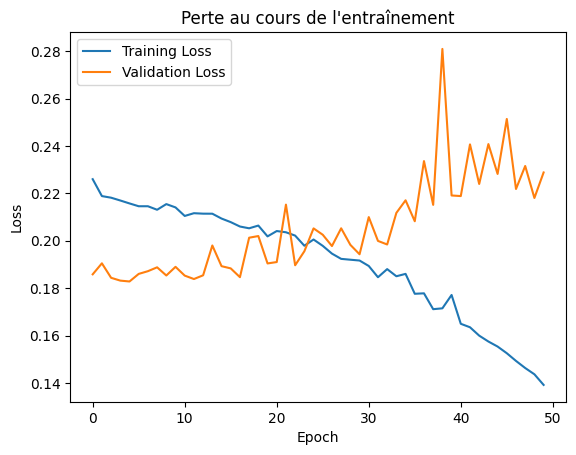

In [53]:
import matplotlib.pyplot as plt

# Courbes de perte
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Perte au cours de l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [54]:
y_pred = model.predict(X_test_scaled)

# Comparer quelques exemples
for i in range(5):  # Afficher les 5 premières prédictions
    print(f"Vraie valeur: {y_test[i]}, Prédiction: {y_pred[i][0]}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Vraie valeur: 0, Prédiction: 0.04291025921702385
Vraie valeur: 0, Prédiction: 0.009889766573905945
Vraie valeur: 0, Prédiction: -0.018552791327238083
Vraie valeur: 0, Prédiction: 0.21576255559921265
Vraie valeur: 0, Prédiction: 0.42481788992881775
